<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2025/Practica_8_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 8: Diagnóstico y selección de moelos

En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov e inferencia variacional) problemas de inferencia estadística. En particular, vamos a proponer modelos de probabilidad condicionada con una única variable predictora, ya sea continua o discreta.

Para ello nos montaremos sobre dos librerías (paquetes de funciones)
- [Bambi](https://bambinos.github.io/bambi/) (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- [ArviZ](https://python.arviz.org/en/stable/): para la visualización de los resultados de la inferencia y la evaluación de los modelos

## Librerías

En primer lugar, importamos o instalamos todas las librerías y funciones que utilizaremos a lo largo del Colab.

In [1]:
# importar librerias utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# librerias para abrir archivos
import io
from google.colab import files

# instalar bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 904.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.3 MB/s eta 0:00:00


## Funciones útiles (creadas por nosotros)

### Para QQ-Plots

In [2]:
def qqplot(x,y):
# FUNCION PARA GRAFICAR QQ-PLOTS
# x es el vector con los datos obtenidos mediante simulacion
# y es el vector con los datos muestras
# La funcion asume que el vector x tiene más elementos que el vector y

  from scipy.interpolate import interp1d
  from statsmodels.distributions.empirical_distribution import ECDF
  # Funciones acumuladas empíricas
  CDFx = ECDF(x)
  CDFy = ECDF(y)

  # Factores de Correccion
  Nx = len(CDFx.x)-1
  CDFx.y = CDFx.y*Nx/(Nx+1)
  Ny = len(CDFy.x)-1
  CDFy.y = CDFy.y*Ny/(Ny+1)

  # Interpolación lineal para CDFx
  CDFx_interp = interp1d(CDFx.y[1:],CDFx.x[1:])

  # Cuantiles de Y
  Qy = CDFy.x[1:]
  # Encontrar los cuantiles de de x asociados a los de y
  Qx = np.zeros(len(Qy))
  for i in range(len(Qy)):
    Qx[i] = CDFx_interp(CDFy.y[i+1])

  return Qx, Qy

In [3]:
def plot_qqplot(inference_data,y,num_pp_samples,ax=None):
  # Graficar QQ-plot

  X = inference_data.posterior_predictive[y].values
  y = inference_data.observed_data[y].values

  # Plot
  if ax == None:
    fig, ax = plt.subplots(figsize=(5,5))

  # Post predictives
  for i in range(num_pp_samples):
    Qx, Qy = qqplot(np.ravel(X),np.reshape(np.ravel(X),(-1,len(y))).T[:,np.random.randint(0,len(np.reshape(np.ravel(X),(-1,len(y)))))])
    xmin = np.min([np.min(Qx),np.min(Qy)])
    xmax = np.max([np.max(Qx),np.max(Qy)])
    ax.plot( Qx, Qy, alpha=0.2, color='C0', linewidth=1.5)

  # Observed
  Qx, Qy = qqplot(np.ravel(X),y)
  xmin = np.min([np.min(Qx),np.min(Qy)])
  xmax = np.max([np.max(Qx),np.max(Qy)])
  ax.plot( Qx, Qy, color='k', linewidth=2)

  ax.plot([xmin,xmax],[xmin,xmax], color='C1', linestyle='--')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(xmin,xmax)
  ax.grid()
  ax.set_xlabel('Cuantiles Simulación')
  ax.set_ylabel('Cuantiles Muestras')
  #plt.show()

### Para residuos

In [4]:
def plot_residuos(dataframe,inference_data,y,x=None,num_pp_samples=np.nan,fig_size=(6,3)):
  # valores observados
  y_obs = inference_data.observed_data[y].values
  # valores predichos
  mu_est = inference_data.posterior['mu'].values

  if np.isnan(num_pp_samples):
    num_pp_samples = len(dataframe)

  fig, ax = plt.subplots(figsize=fig_size)
  for i in range(0,num_pp_samples):
    residuals = y_obs - mu_est[0,i,:]
    sns.kdeplot(residuals, ax=ax, linewidth=.3, alpha=.3, color='C0' )

  sns.kdeplot(y_obs-mu_est.mean(axis=(0,1)), ax=ax, linewidth=1., color='k' )
  ax.axvline(x=0, linestyle='--', color='gray', linewidth=1.5)

  ax.grid(True)
  ax.set_xlabel('residuos')
  ax.set_xlim(np.min(-np.abs(residuals))*1.5,np.max(np.abs(residuals))*1.5)
  return fig, ax

In [5]:
def plot_residuos_2(dataframe,inference_data,y,x=None,hdi_prob=0.94,fig_size=(6,3)):
  # valores observados
  y_obs = inference_data.observed_data[y].values
  # valores predichos
  mu_est = inference_data.posterior['mu'].values

  # eje X
  if x is None:
    x_obs = mu_est.mean(axis=(0,1))
  else:
    x_obs = dataframe[x].values

  fig, ax = plt.subplots(figsize=fig_size)
  for i in range(len(dataframe)):
    residuals = y_obs[i] - mu_est.mean(axis=(0,1))[i]
    quantiles = az.hdi(np.ravel(y_obs[i]-mu_est[:,:,i]),hdi_prob=hdi_prob)
    ax.plot( [x_obs[i],x_obs[i]], quantiles, color='gray', alpha=.3 )
    ax.plot( x_obs[i], residuals.mean(), 'o', color='C0', markersize=2)

  ax.axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
  ax.set_ylabel('residuo')
  if x is None:
    ax.set_xlabel(y)
  else:
    ax.set_xlabel(x)
  ax.grid(True)

  lim = np.max(np.abs(np.mean(y_obs-mu_est,axis=(0,1))))*1.5
  ax.set_ylim(-lim,lim)
  return fig, ax

## Ejemplo 1: Resistencia del hormigón como función de la relación agua-material cementicio

En este primer ejercicio, buscaremos responder la siguiente pregunta:

**- ¿Cuál es la resistencia característica de un hormigón con relación agua-cemento (o material cementicio) de 0.4? ¿y si es 0.5?**

Para eso, vamos a usar los datos de ensayos de probetas que tenemos disponibles y ajustar un modelo.

### El dataset

Contamos con 103 muestras de hormigón ensayadas a los 28 días. Las mismas se extrajeron de un dataset público disponible en el repositorio de la Universidad de California Irvine. Pueden acceder al dataset haciendo click [aquí](https://archive.ics.uci.edu/dataset/182/concrete+slump+test).

Este dataset elaborado por I-Cheng Yeh ha sido utilizado en numerosas investigaciones.

In [6]:
# Subir archivo al colab
uploaded = files.upload()

Saving concrete_tests.xlsx to concrete_tests.xlsx


In [7]:
# Creamos el dataframe
df_horm = pd.read_excel(io.BytesIO(uploaded['concrete_tests.xlsx']))
df_horm

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0        62.0                               34.99  
1        20.0                               41.14  
2        20.0                               41.81  
3        21.5                               42.08  
4        64.0                               26.82  
..        ...                                 ...  
98       20.0                               49.97  
99       20.0                               50.23  
100      20.0                               50.50  
101      67.0                               49.17  
102      78.0                               48.77  

[103 rows x 10 columns]

Lo primero que vamos a hacer es, en forma rápida, crear una nueva columna de nombre `a_c` que represente la relación agua-material cementicio, que incluye el cemento, la escoria y las cenizas volantes.

También cambiaremos el nombre de la columna de resistencia para hacerlo más amigable.

In [8]:
# Construimos una variable a/c (relacion agua cemento)
df_horm['a_c'] = df_horm['Water']/(df_horm['Cement']+df_horm['Slag']+df_horm['Fly ash'])

# cambiamos el nombre de la resistencia a la compresion
df_horm.rename(columns={'Compressive Strength (28-day)(Mpa)': 'Resistencia_MPa'}, inplace=True)

df_horm

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
0     273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
1     163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
2     162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
3     162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
4     154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   
..      ...    ...      ...    ...   ...           ...         ...        ...   
98    248.3  101.0    239.1  168.9   7.7         954.2       640.6        0.0   
99    248.0  101.0    239.9  169.1   7.7         949.9       644.1        2.0   
100   258.8   88.0    239.6  175.3   7.6         938.9       646.0        0.0   
101   297.1   40.9    239.9  194.0   7.5         908.9       651.8       27.5   
102   348.7    0.1    223.1  208.5   9.6         786.2       758.1       29.0   

     FLOW(cm)  Resistencia_MPa       a_c  
0        62.0            34.99  0.456522  
1        20.0            41.14  0.357853  
2        20.0            41.81  0.357285  
3        21.5            42.08  0.358000  
4        64.0            26.82  0.536585  
..        ...              ...       ...  
98       20.0            49.97  0.287050  
99       20.0            50.23  0.287146  
100      20.0            50.50  0.298943  
101      67.0            49.17  0.335698  
102      78.0            48.77  0.364574  

[103 rows x 11 columns]

Ya que queremos predecir la resistencia del hormigón para una determinada relación agua-cemento, veamos cómo interactuan estas dos variables entre sí en el dataset.

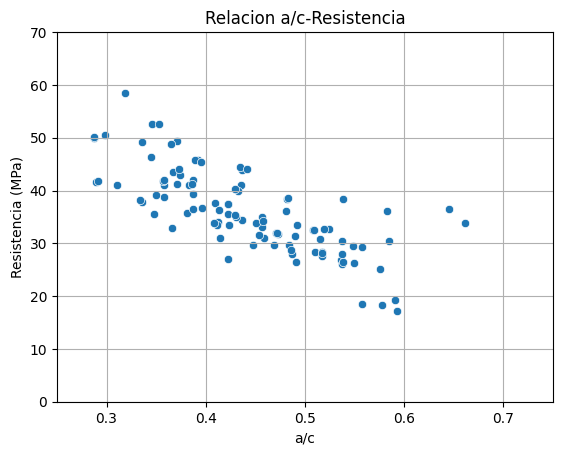

In [9]:
# graficamos la relacion a/c-Resistencia
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa')
plt.grid(True)
plt.xlabel('a/c')
plt.ylabel('Resistencia (MPa)')
plt.title('Relacion a/c-Resistencia')
plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Viendo el gráfico podrán notar dos cosas. Por un lado, no hay un sólo dato que tenga las relaciones agua-cemento que me interesan predecir. "No tengo los datos" para hacer un modelo de inferencia como veníamos trabajando hasta ahora (más allá de asumir que la `a/c` no importa y agrupar todo). Sin embargo, parece haber claramente una relación entre `a/c` y la resistencia ensayada de las probetas.

Por lo tanto, si pudiesemenos ajustar un modelo que determine cómo es esa relación entre `a/c` y la resistencia, podríamos luego usarlo para predecir datos nunca vistos como los pedidos al principio del problema.

### Modelo 1: Recta + error

El modelo más sencillo que podríamos plantear es una recta. Más formalmente, un modelo donde el valor medio es explicado por una recta a la que se le suma un término de error aleatorio.

$$y = A + B\cdot a/c + error$$

$$error \sim Normal(0,\sigma)$$

Otra forma de plantear esto mismo más genérica es como un modelo de probabilidad condicional. Es decir, la resistencia de la probeta dada la relación agua-cemento sigue una distribución normal cuyo valor medio depende de esta relación agua-cemento (en forma lineal).

$$Y \sim Normal(\mu,\sigma)$$

$$\mu = A + B \cdot a/c$$

Para nuestro proceso de inferencia, donde aplicaremos el teorema de bayes para definir la densidad de probabilidad posterior de los parámetros $A$, $B$, $\sigma$, necesitamos primer definir distribuciones a priori. Es decir, la probabilidad de que los parámetros tomen determinados valores *antes* de ver los datos.

Nosotros vamos a dejar que `Bambi` adopte distribuciones poco informativas por nosotros:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

#### Modelo

Cargar este modelo en `Bambi` es bastante sencillo, ya que el modelo normal (`family='gaussian'`) es el default del programa, y la ecuación para el valor medio (`link='identity'`) es el default para el modelo normal.

Por lo tanto, simplemente hay que indicar la columna del dataset que se quiere predecir (`Resistencia_MPa`) y las variables explicativas (`a_c`). `Bambi` automáticamente hace lo siguiente:

- Agrega una ordenada al origen o "Intercept" (lo que habíamos llamado $A$)
- Multiplica a la variable predictora por una constante con el mismo nombre. Es decir, llama $a\_c$ al parámetro que multiplica al predictor `a_c` del dataset (lo que habíamos llamado $B$)
- Genera el parámetro del desvío de la normal "sigma" ($\sigma$).

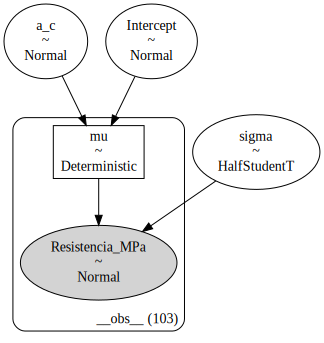

In [10]:
# creamos un modelo lineal (con error absoluto)
model_1 = bmb.Model('Resistencia_MPa ~ a_c', data=df_horm)
model_1.build()

# visualizacion
model_1.graph()

#### Prioris

Si bien arriba se puede ver en forma esquemática cómo funciona el modelo y las distribuciones a priori adotptadas, siempre es bueno visualizarlas para ver si están transmitiendo la información previa que nosotros queremos (o la no-información)

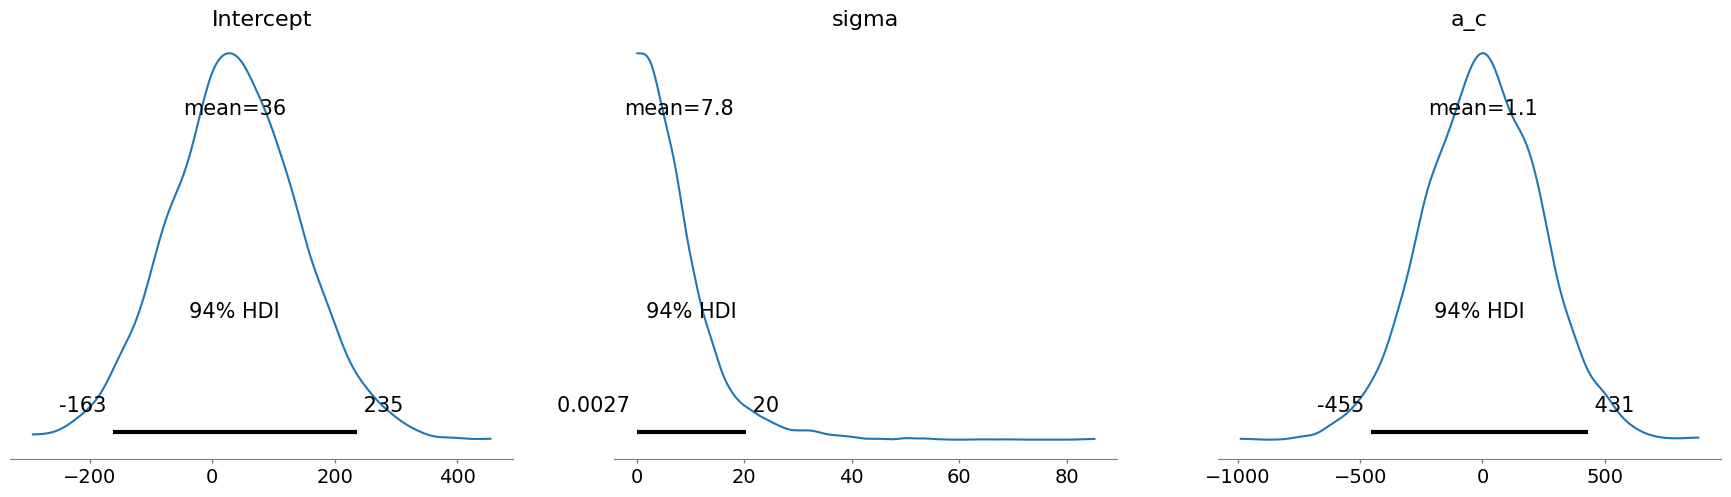

In [11]:
# ver distribuciones a priori
model_1.plot_priors()
plt.show()

#### Inferencia

Si ya tenemos nuestro modelo construido de acuerdo a nuestras necesidades, procedemos a hacer la inferencia. En este paso generaremos simulaciones de la distribución posterior de los parámetros ($Intercept$, $a\_c$, $sigma$) mediante cadenas de Markov. Estas se guardaran en mi variable `results_1`

Para asegurarnos que esté todo ok, revisamos que no haya divergencias durante el proceso, y que las cadenas hayan convergado tanto internamente como entre sí, pareciéndose a un ruido blanco.

Output()

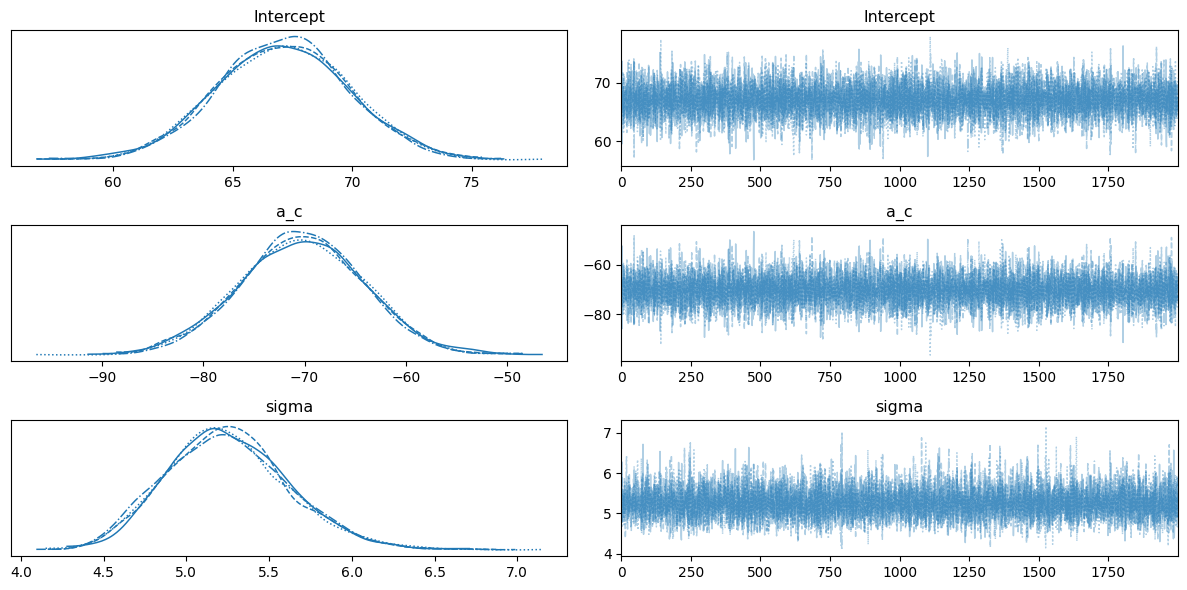

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  67.109  2.768  61.946   72.302      0.025    0.031   12578.0   
a_c       -70.243  6.131 -81.491  -58.534      0.054    0.068   12763.0   
sigma       5.254  0.376   4.583    5.970      0.003    0.005   13052.0   

           ess_tail  r_hat  
Intercept    6882.0    1.0  
a_c          6730.0    1.0  
sigma        6221.0    1.0

In [12]:
# Realizar la inferencia
results_1 = model_1.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_1)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_1)

¡En este caso todo parece andar bien!

#### Posterior

Si nuestra inferencia salió bien, ya podemos empezar a ver qué me dice. Por ejemplo, lo primero que puedo ver es cuánto valen los parámetros de mi modelo. Es decir, su distribución posterior (dado que tengo estos datos, ¿cuál es la probabilidad de que los parámetros valgan determinado valor?).

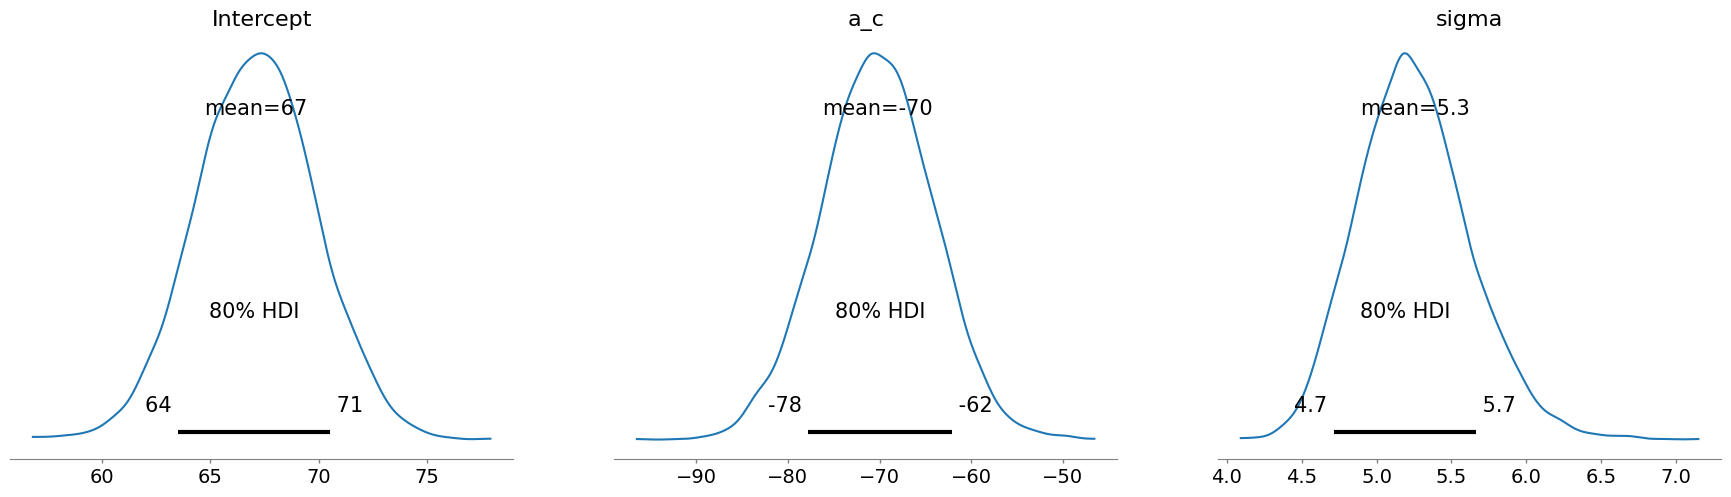

In [13]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_1,hdi_prob=0.8)
plt.show()

Es posible acceder manualmente a las simulaciones si así se requiere dentro de mi Inference Data (`results_1`). Fijensé que es clickeable, y pueden explorar todo lo que tiene. En particular, pueden acceder a las simulaciones de los parámetros.

In [14]:
results_1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Por ejemplo, puedo extraer la matriz con las simulaciones de la pendiente de la recta $a\_c$ de la siguiente forma:

**Nota:** Las dimensiones son (4,2000): 4 cadenas, 2000 simulaciones por cadena.

In [15]:
results_1.posterior['a_c'].values

array([[-71.40768756, -69.54540697, -52.33205897, ..., -64.97795463,
        -67.67512899, -71.13127643],
       [-73.23498992, -65.6751525 , -75.96932124, ..., -74.37714861,
        -63.42467692, -65.94842069],
       [-69.77138311, -75.39833244, -66.33445944, ..., -68.09303707,
        -74.63716519, -72.92135876],
       [-70.65403685, -75.75599637, -65.80369268, ..., -68.1865172 ,
        -71.94954333, -78.18762067]])

#### Visualización del ajuste

Si bien lo anterior me dice cuánto valen los parámetros, no me permite ver rápidamente cómo funciona mi modelo y qué predice. Y si no me dice qué predice, dificilmente pueda sacar conclusiones reales ni verificar si se ajusta bien a los datos disponibles.

Para hacer eso podemos usar la función de `bambi` "[interpret.plot_predictions()](https://bambinos.github.io/bambi/api/interpret.plot_predictions.html)". En esta se introduce:

- El modelo
- El Inference Data con las simulaciones de los parámetros
- Qué variables predictoras considerar en el eje $X$ y (opcional) en qué valores evaluarlas
- Si se quiere graficar el valor medio (`pps=False`) o valores puntuales de la variable a predecir (`pps=True`)
- El intervalo de confianza a graficar

A medida que sea necesario, iremos introduciendo más opciones disponibles en esta función.

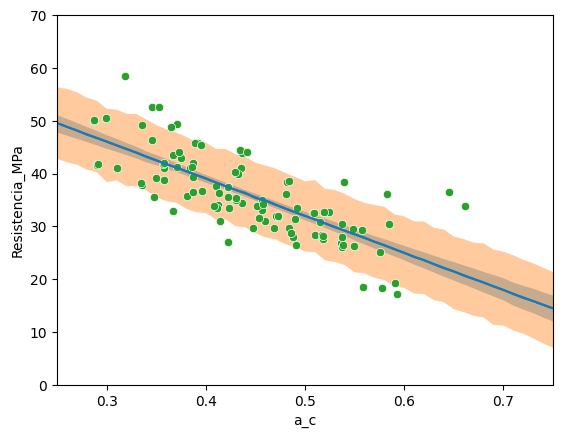

In [16]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_1,results_1,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_1,results_1,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Vean que ahora se ve mucho más claro qué me dice el modelo. Por ejemplo, se ve visualmente cuánto cae la resistencia a medida que aumenta la proporción de agua en la mezcla. También se puede ver la incertidumbre en el valor medio (sombra azul), y la dispersión de resultados de una muestra en particular (sombra naranja).

Efectivamente no hice más que ajustar una recta, pero incluyendo incertidumbres.

Luego, podremos discutir si el ajuste es bueno o no (por ejemplo, pareciera que subestimo los datos de las puntas y tiendo a sobreestimar en valores "medios" de agua-cemento.

### Diagnóstico del Modelo 1

#### Verificación de la posterior predictiva

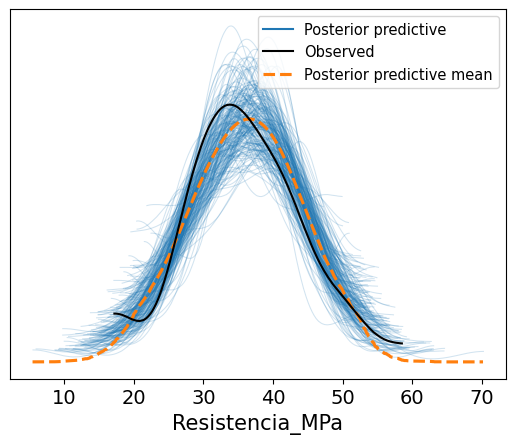

In [17]:
# Genero réplicas de mi dataset
model_1.predict(results_1,kind='response')

# Evaluación de la posterior predictiva
az.plot_ppc(results_1,num_pp_samples = 200)
plt.show()

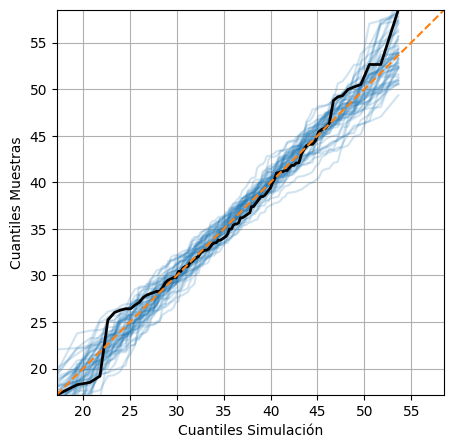

In [18]:
# QQ-PLOT
plot_qqplot(results_1,'Resistencia_MPa',50)
plt.show()

#### Análisis de residuos

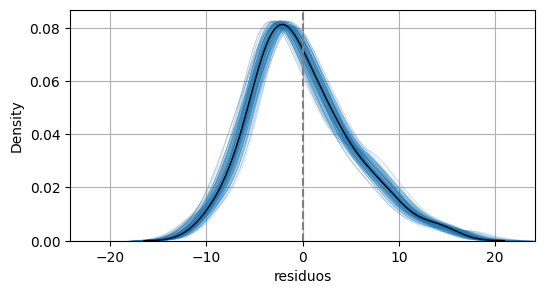

In [19]:
fig, ax = plot_residuos(df_horm,results_1,'Resistencia_MPa',num_pp_samples=200)
plt.show()

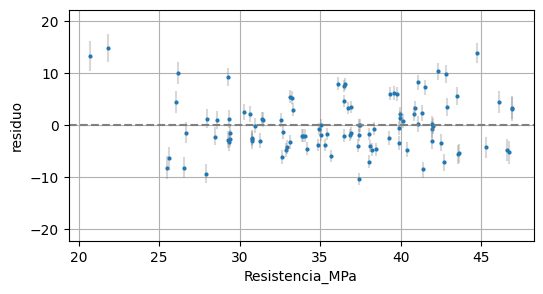

In [20]:
fig, ax = plot_residuos_2(df_horm,results_1,y='Resistencia_MPa')
plt.show()

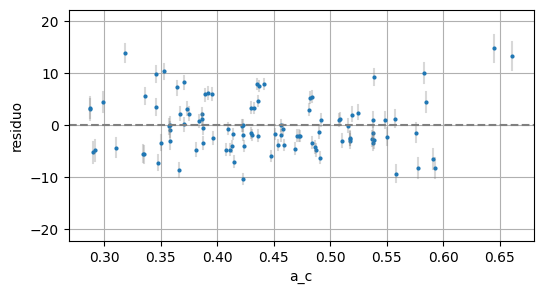

In [21]:
fig, ax = plot_residuos_2(df_horm,results_1,y='Resistencia_MPa',x='a_c')
plt.show()

### Modelos potencialmente mejores

#### Modelo 2: Hipérbola + error

Este proceso que aplicamos recién podemos usarlo para prácticamente cualquier otro modelo de inferencia. De aquí en más vamos a ir planteando otros modelos simplemente para mostrar distintas variantes que pueden aparecer a la hora de definir el modelo. ¡Todo lo demás es igual!

Uno podía ver los datos de arriba y pensar que la mejor forma de ajustar los datos es con una hipérbola:

$$y = \frac{1}{A\cdot a/c} + error$$

$$error \sim Normal(0,\sigma)$$

Escrito en el formato que venimos manejando a lo largo de la materia, esto sería:

$$Y \sim Normal(\mu,\sigma)$$

$$\frac{1}{\mu} = A\cdot a/c$$

**Noten que la ecuación está definida para la inversa del valor medio, y que no tiene ordenada al origen**. Luego, definimos distribuciones a priori para los parámetros $A$ y $\sigma$

$$p(A) \sim Exponential(1)$$
$$p(\sigma) \sim Exponential(1)$$

Para cargarlo en `Bambi` debo tener únicamente el cuidado de aclarar el `link='inverse', ya que la ecuación se definió para la inversa del valor medio. Por otro lado, para decir no hay ordenada al origen (no hay "Intercept") lo dejo explicitado con un $0$ en la ecuación

**Nota**: En este caso se definieron a mano las distribuciones a priori porque el link utilizado no es el default para la distribución normal.

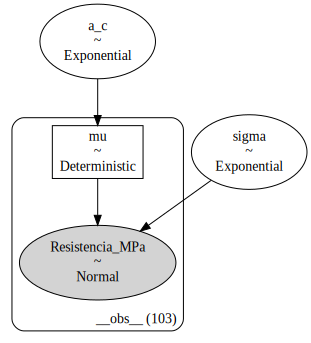

In [22]:
# creamos un modelo hiperbólico (con error absoluto)
prioris = {'a_c':bmb.Prior('Exponential',lam=1),'sigma':bmb.Prior('Exponential',lam=1)}

model_2 = bmb.Model('Resistencia_MPa ~ 0 + a_c', data=df_horm,link='inverse',priors=prioris)
model_2.build()

# visualizacion
model_2.graph()

Puedo ver las prioris que adopté:

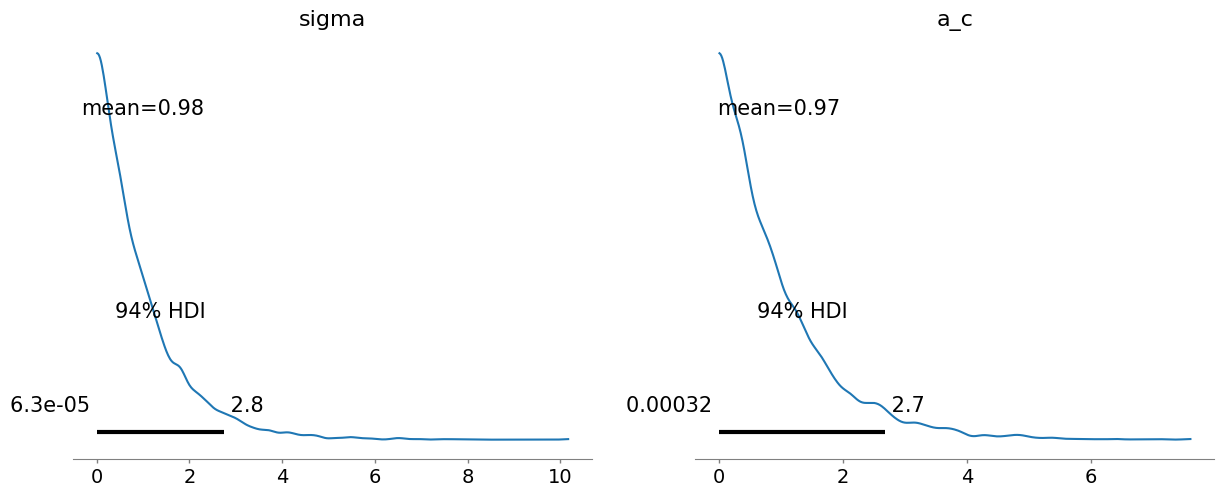

In [23]:
# ver distribuciones a priori
model_2.plot_priors()
plt.show()

Hacer la inferencia y chequear la convergencia de las cadenas:

Output()

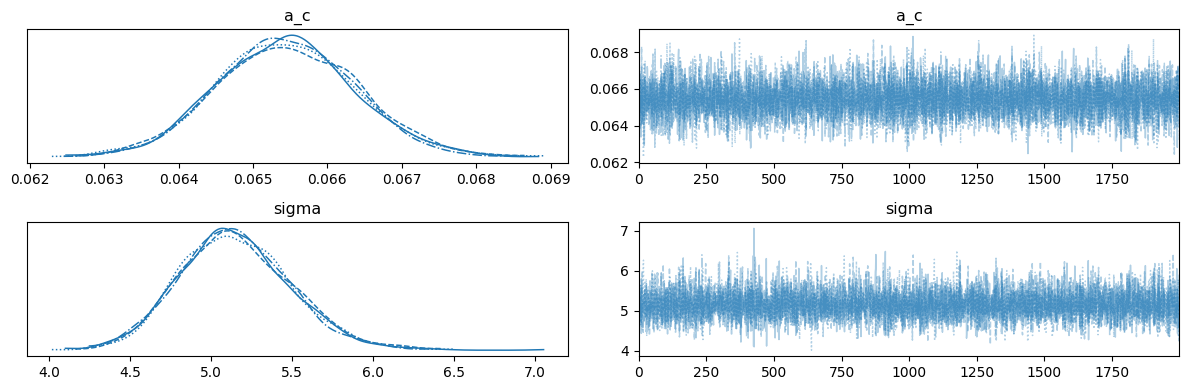

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_c    0.065  0.001   0.064    0.067      0.000    0.000    8085.0    6003.0   
sigma  5.151  0.343   4.519    5.798      0.004    0.004    7442.0    5768.0   

       r_hat  
a_c      1.0  
sigma    1.0

In [24]:
# Realizar la inferencia
results_2 = model_2.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_2)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_2)

Ver la distribución posterior de los parámetros:

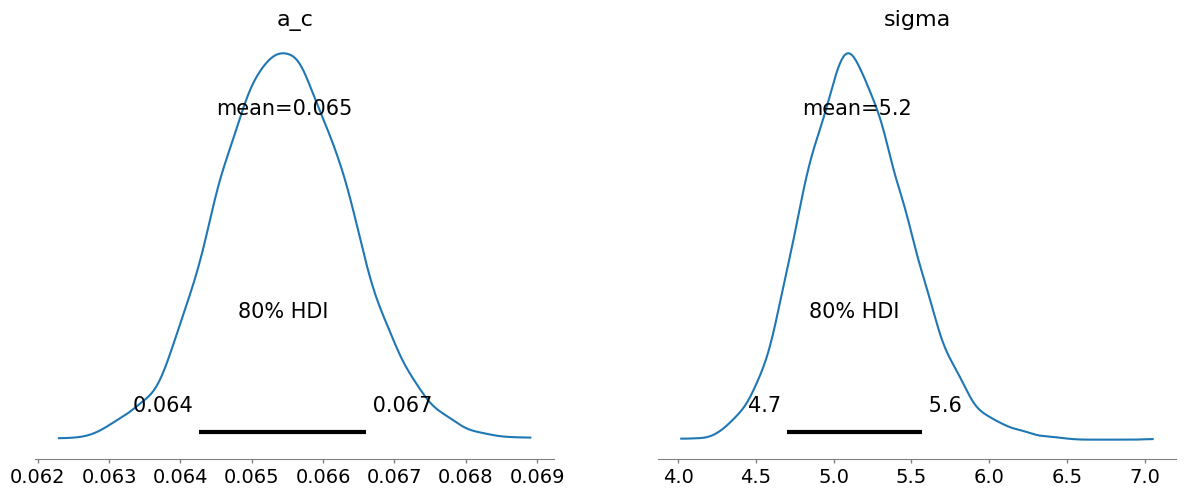

In [25]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_2,hdi_prob=0.8)
plt.show()

Y visualizar el ajuste de la hipérbola con los intervalos de confianza. ¡Todo es exactamente igual que antes!

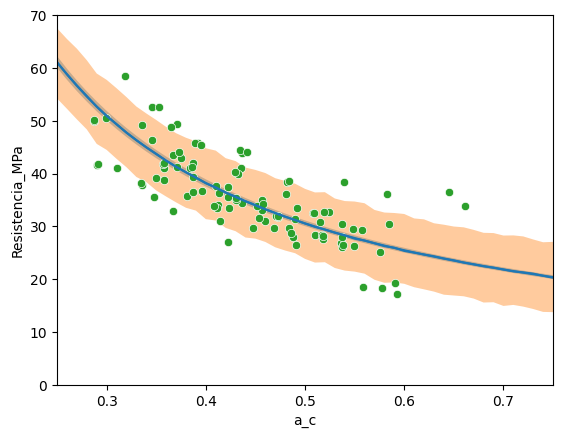

In [26]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_2,results_2,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_2,results_2,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

#### Modelo 3: Parábola + error

También podríamos probar de ajustar una parábola a los datos:

$$y = A + B\cdot a/c + C\cdot {a/c}^{2} + error$$

$$error \sim Normal(0,\sigma)$$

Escrito en el formato que venimos manejando a lo largo de la materia, esto sería:

$$Y \sim Normal(\mu,\sigma)$$

$$\mu = A + B\cdot a/c + C\cdot {a/c}^{2}$$

Con las distribuciones a priori de los parámetros definidas automáticamente por `Bambi`:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(C) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

Para cargarlo en `Bambi`, lo más importante es saber que si algo se escribe entre llaves `{ }`, entonces eso lo considera una "cuenta matemática determinística". Por ejemplo, si quiero que algo depende de $X^{2}$, siendo $X$ una columna de mi dataframe, escribiría `{X**2}`. Con esto, `Bambi` sabe automáticamente que debe tomar la variable `X` y llevarlo al cuadrado.

Esto es mucho mejor que crear una columna en mi dataset con $X^{2}$ porque a fin de cuentas mi predictor es $X$, el cuadrado simplemente indica cómo mi problema se relaciona con $X$. No son dos predictores distintos.

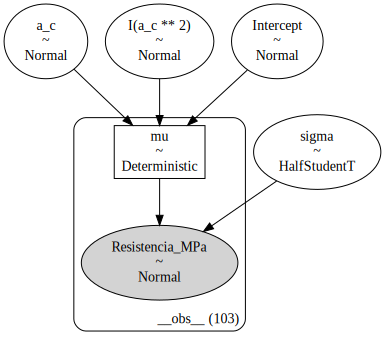

In [27]:
# creamos un modelo parabolico (con error absoluto)
model_3 = bmb.Model('Resistencia_MPa ~ a_c + {a_c**2}', data=df_horm)
model_3.build()

# visualizacion
model_3.graph()

Después, todo lo demás sigue igual...

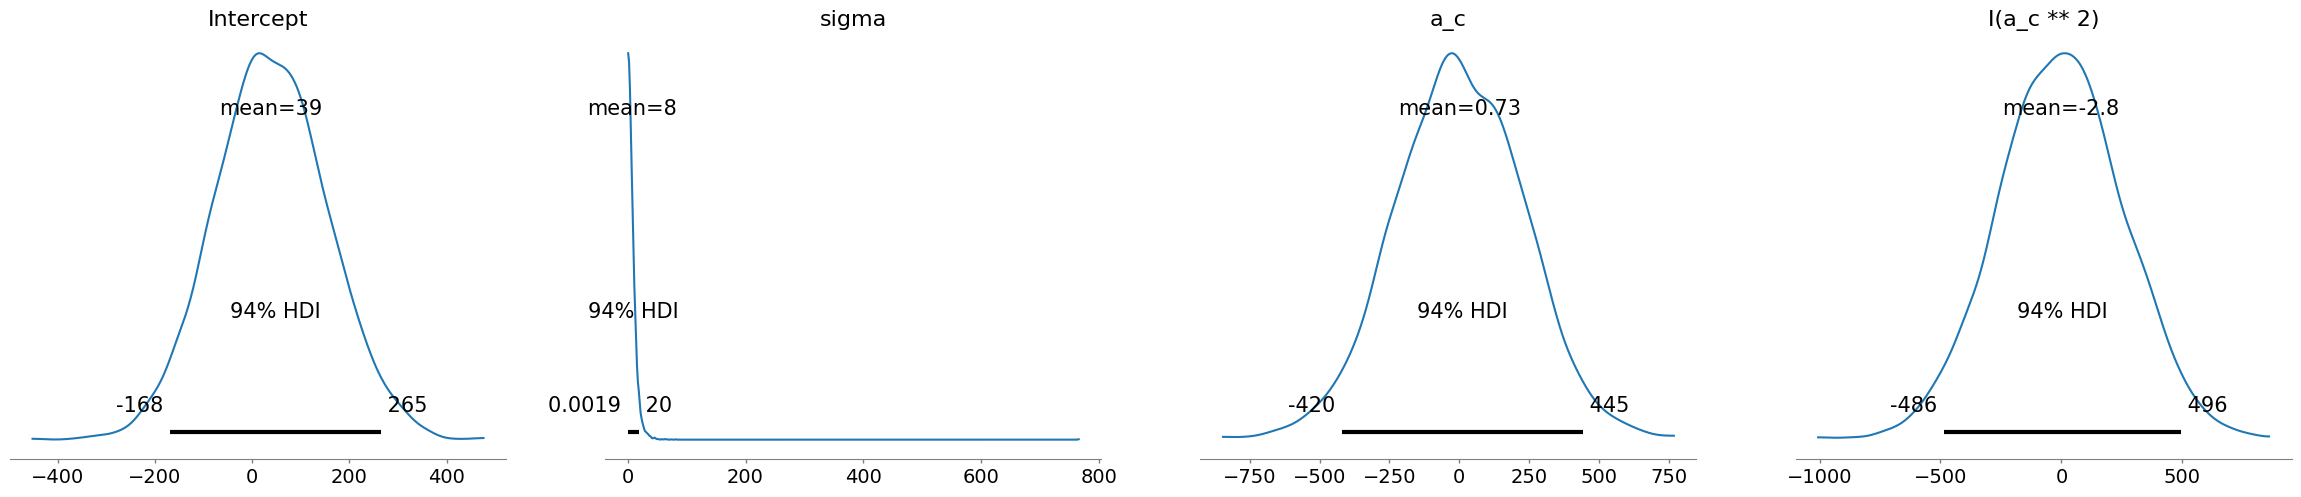

In [28]:
# ver distribuciones a priori
model_3.plot_priors()
plt.show()

Output()

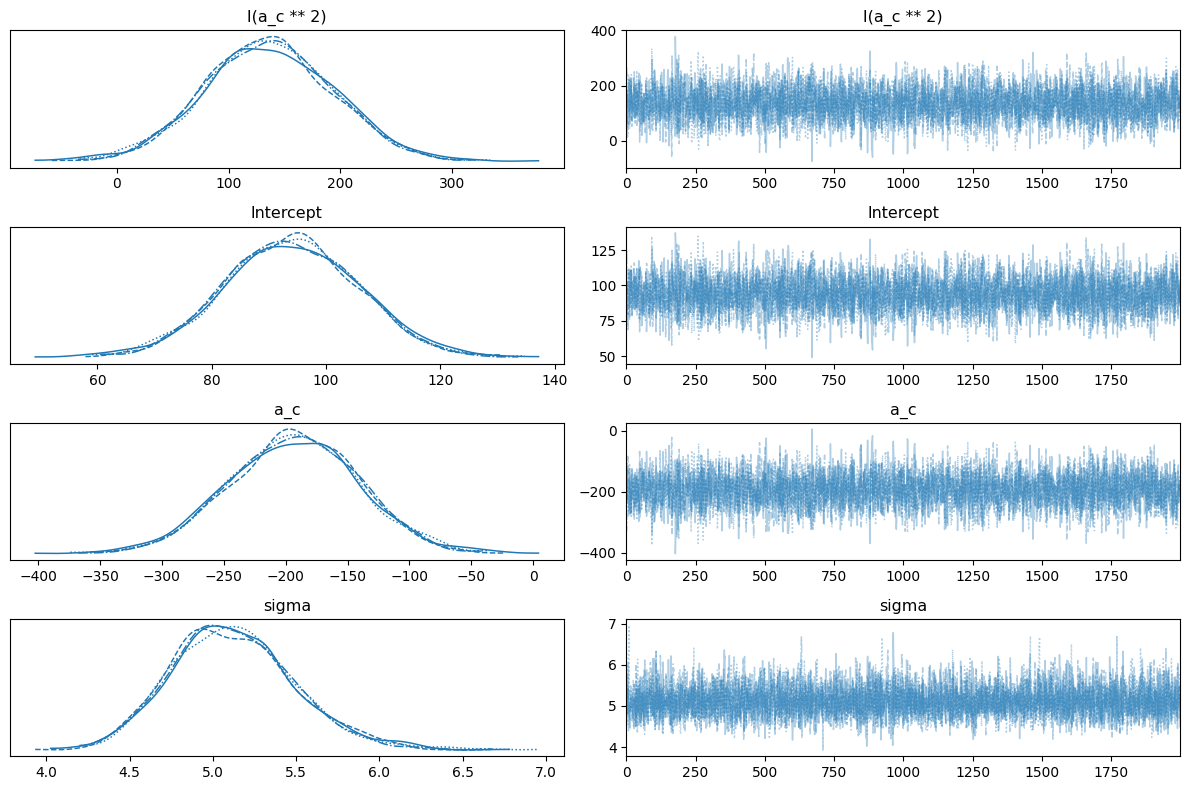

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I(a_c ** 2)  135.996  57.332   29.033  243.074      0.934    0.728    3763.0   
Intercept     93.998  11.675   72.082  115.770      0.188    0.148    3850.0   
a_c         -193.300  52.259 -289.401  -94.669      0.850    0.671    3778.0   
sigma          5.121   0.369    4.420    5.783      0.005    0.005    5777.0   

             ess_tail  r_hat  
I(a_c ** 2)    4202.0    1.0  
Intercept      4365.0    1.0  
a_c            4193.0    1.0  
sigma          4466.0    1.0

In [29]:
# Realizar la inferencia
results_3 = model_3.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_3)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_3)

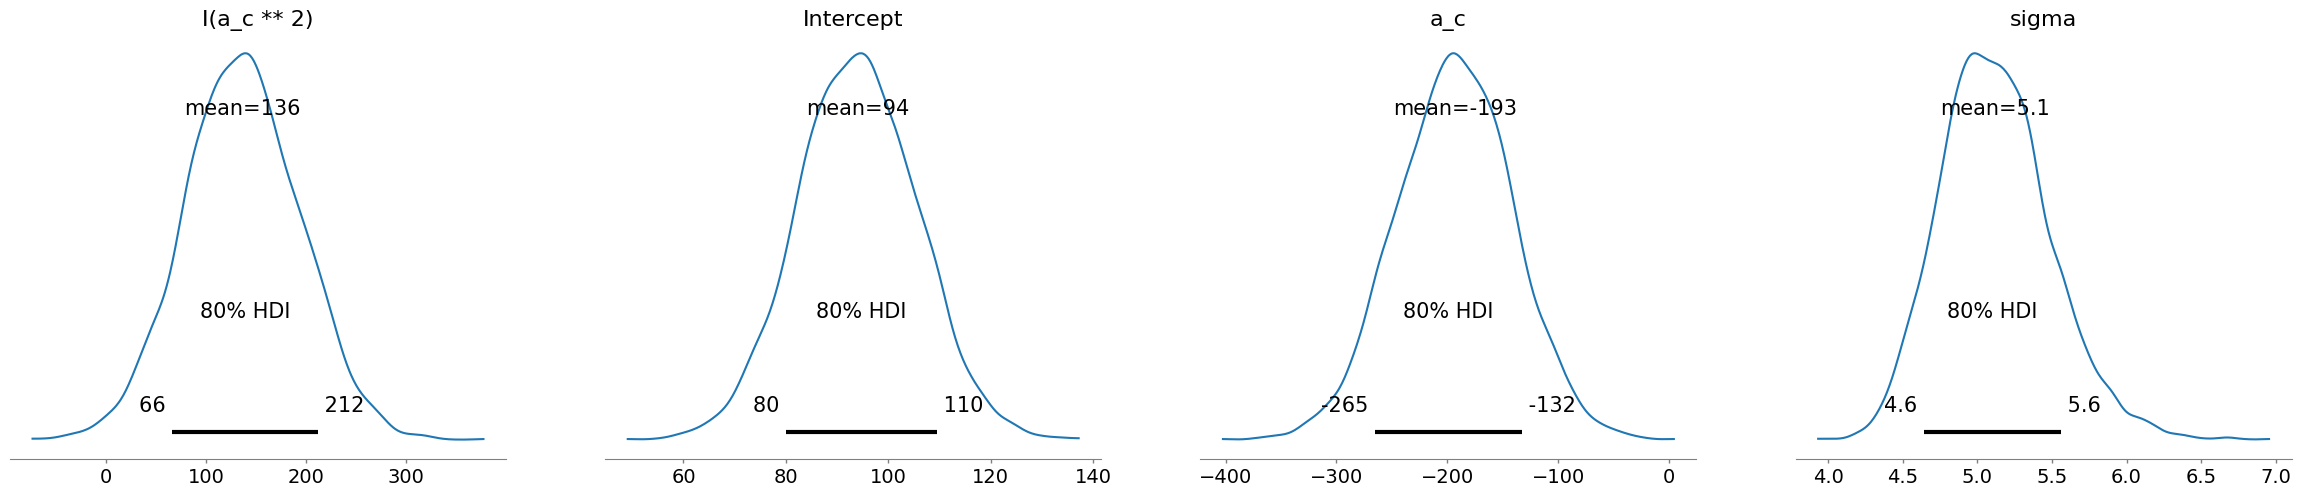

In [30]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_3,hdi_prob=0.8)
plt.show()

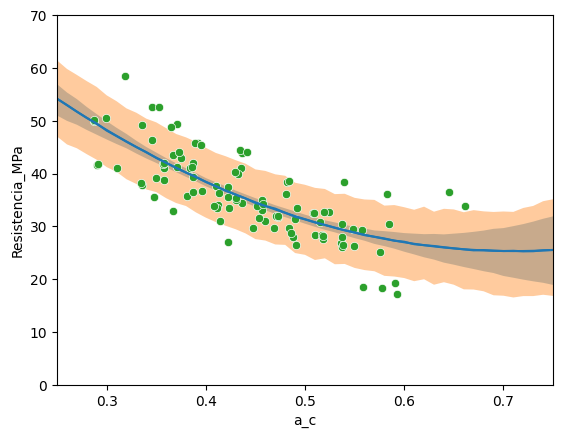

In [31]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_3,results_3,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_3,results_3,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

#### Modelo 4: Ley de Abrams (modelo lognormal)

Por último, vamos a ver cómo cargar un modelo lognormal. Como excusa, veremos la Ley de Abrams (no significa que el modelo de Abrams necesariamente sea lognormal)

Por empezar, recordemos que una variable $Y$ es lognormal si su logaritmo $Z=\log Y$ es normal. Entonces, si tratamos al modelo normal como uno de "valor medio más un error", como venimos haciendo:

$$Z = \log Y = \mu_{z} + error$$

$$error \sim Normal(0,\sigma)$$

Entonces el modelo para la variable $Y$ original me queda:

$$e^{Z} = Y = e^{\mu_{z}} \cdot e^{error}$$

¡Es un producto! En particular, un producto entre la mediana de $Y$ y un término de error que sigue una distribución lognormal de mediana igual a 1 y coeficiente de variación $\sigma$.

**En resumen**: Un modelo lognormal es un modelo donde se ajusta una curva para la mediana (en realidad, el valor medio del logaritmo), y el error se propaga como un error *relativo* definido por el parámetro $\sigma$ (el desvío estandar del logaritmo).

Aplicado a la Ley de Abrams, tenemos lo siguiente. Primero, la ecuación para la **mediana** es, según Abrams:

$$\bar y = \frac{c_{1}}{{c_{2}}^{a/c}}$$

El modelo que vamos a adoptar es de errores relativos (lognormal), por lo tanto:

$$y = \frac{c_{1}}{{c_{2}}^{a/c}}\cdot Error$$

donde $Error\sim LN(0,\sigma)$. Tomando el logaritmo, me queda:

$$z = \log c_{1} + \left(-\log c_{2}\right) \cdot a/c + error$$

donde $error \sim N(0,\sigma)$ es el error absoluto, normal, en el logaritmo. Es decir, ¡si tomo el logaritmo a los datos me queda un modelo normal típico como venimos trabajando!

**Resumen**: Por lo tanto, el modelo que estoy ajustando es una recta como venimos haciendo siempre, ¡pero para el logaritmo de las resistencias!

$$\log Y \sim N(\mu,\sigma)$$

$$\mu = A + B\cdot a/c$$

con prioris:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

**Nota**: $A=\log c_{1}$, $B = -\log c_{2}$

##### Construcción

La construcción en `Bambi` de este problema es directa: simplemente aclaro que lo que estoy ajustando es el logaritmo de la columna de Resistencias: `log(Resistencia_MPa)`. El valor medio del logaritmo sigue una recta, por la derivación que hicimos anteriormente.

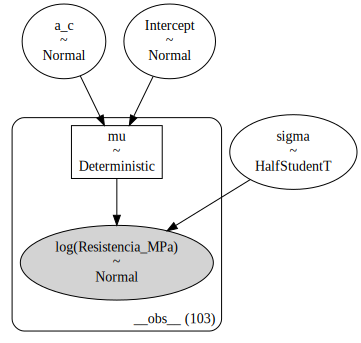

In [32]:
# creamos un modelo de ley de abrams (errores relativos)
model_4 = bmb.Model('log(Resistencia_MPa) ~ a_c', data=df_horm)
model_4.build()

# visualizacion
model_4.graph()

Una vez que llegué acá, es todo lo mismo de antes:

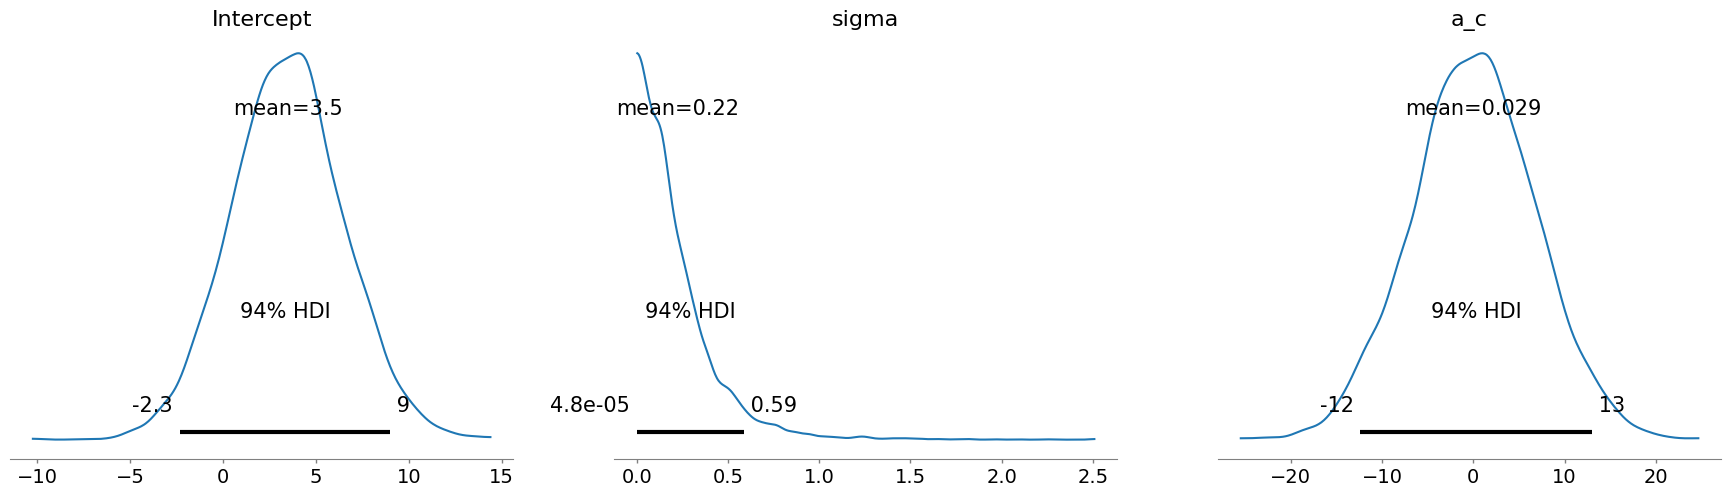

In [33]:
# ver distribuciones a priori
model_4.plot_priors()
plt.show()

Output()

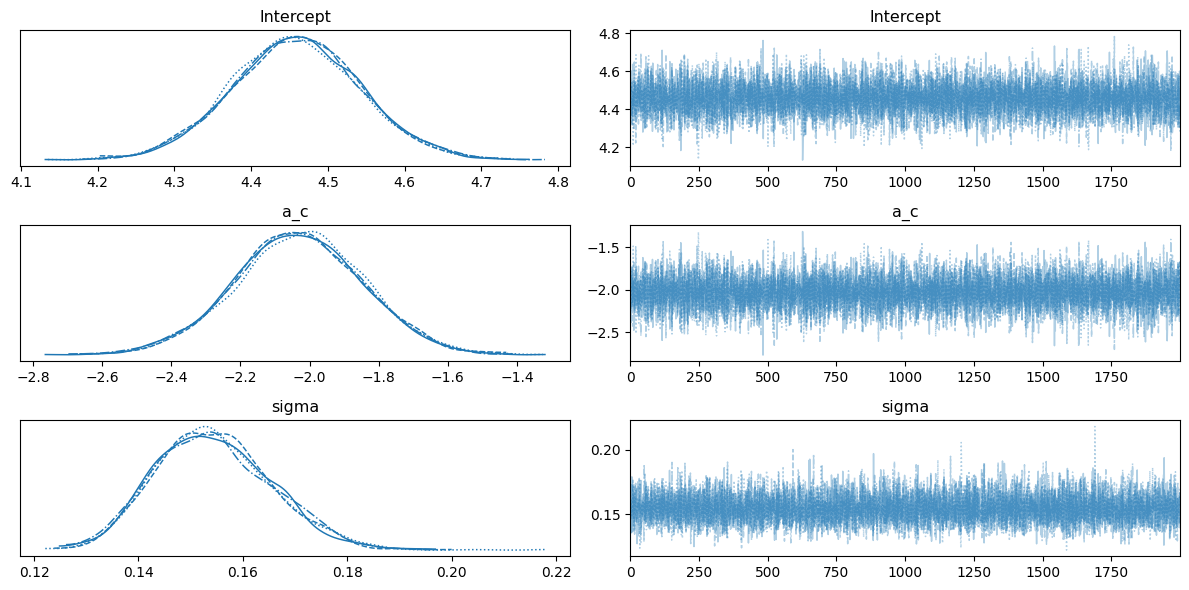

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.458  0.084   4.304    4.622      0.001    0.001   11771.0   
a_c       -2.031  0.186  -2.391   -1.689      0.002    0.002   11822.0   
sigma      0.154  0.011   0.135    0.176      0.000    0.000   10810.0   

           ess_tail  r_hat  
Intercept    6692.0    1.0  
a_c          6720.0    1.0  
sigma        5884.0    1.0

In [34]:
# Realizar la inferencia
results_4 = model_4.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_4)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_4)

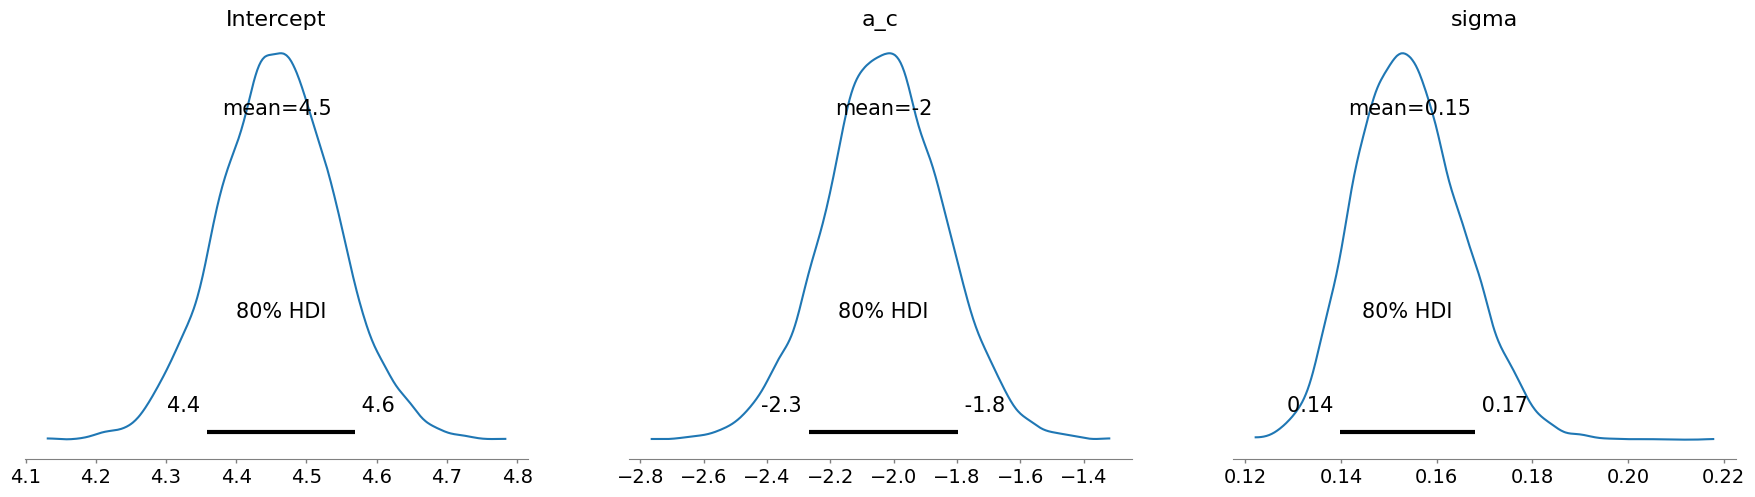

In [35]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_4,hdi_prob=0.8)
plt.show()

El tema aparece a la hora de visualizar la ecuación. Como yo ajuste el logaritmo de la resistencia, el modelo está hecho para predecir logaritmos.

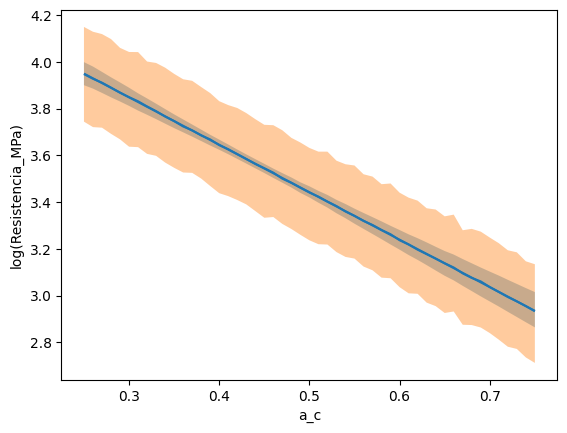

In [36]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)
plt.show()

##### Transformación

Necesitamos, entonces, volver a la escala original en el gráfico de visualización del modelo. Para eso podemos usar la opción `transforms` dentro de la función `interpret.plot_predictions()`.

En este caso, lo que queremos hacer es exponenciar a los logaritmos de la resistencia predichos. Luego, manualmente le cambiamos el nombre del eje $y$ al gráfico.

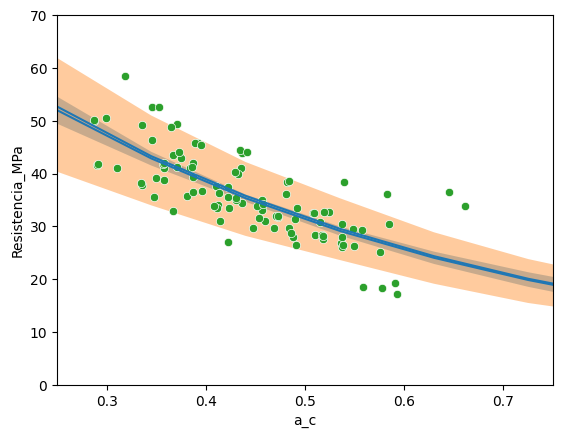

In [37]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,5,51)},transforms={'log(Resistencia_MPa)':lambda x: np.exp(x)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,5,51)},transforms={'log(Resistencia_MPa)':lambda x: np.exp(x)},pps=True,prob=0.8,ax=ax)
plt.ylabel('Resistencia_MPa')

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Noten como la sombra naranja (la dispersión de los resultados) disminuye a medida que disminuye el valor medio predicho. Esto es porque un modelo lognormal, es un modelo de errores relativos.

**Nota**: Que la dispersión se reduzca no parece justificarse por los datos. ¿Cómo podrían hacer para utilizar la ley de Abrams con un modelo de errores absolutos?

#### Modelo 5: Ley de Abrams (modelo normal)

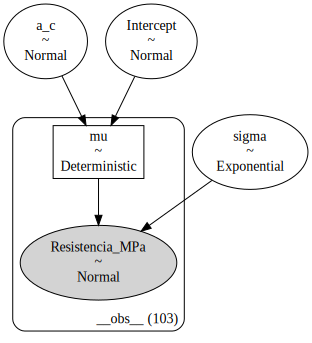

In [38]:
# creamos un modelo de ley de abrams (errores absolutos)
prioris = {'Intercept':bmb.Prior('Normal',mu=3.6,sigma=2.8),
           'a_c':bmb.Prior('Normal',mu=0,sigma=7),
           'sigma':bmb.Prior('Exponential',lam=1)}

model_5 = bmb.Model('Resistencia_MPa ~ a_c', link='log',data=df_horm,priors=prioris)
model_5.build()

# visualizacion
model_5.graph()

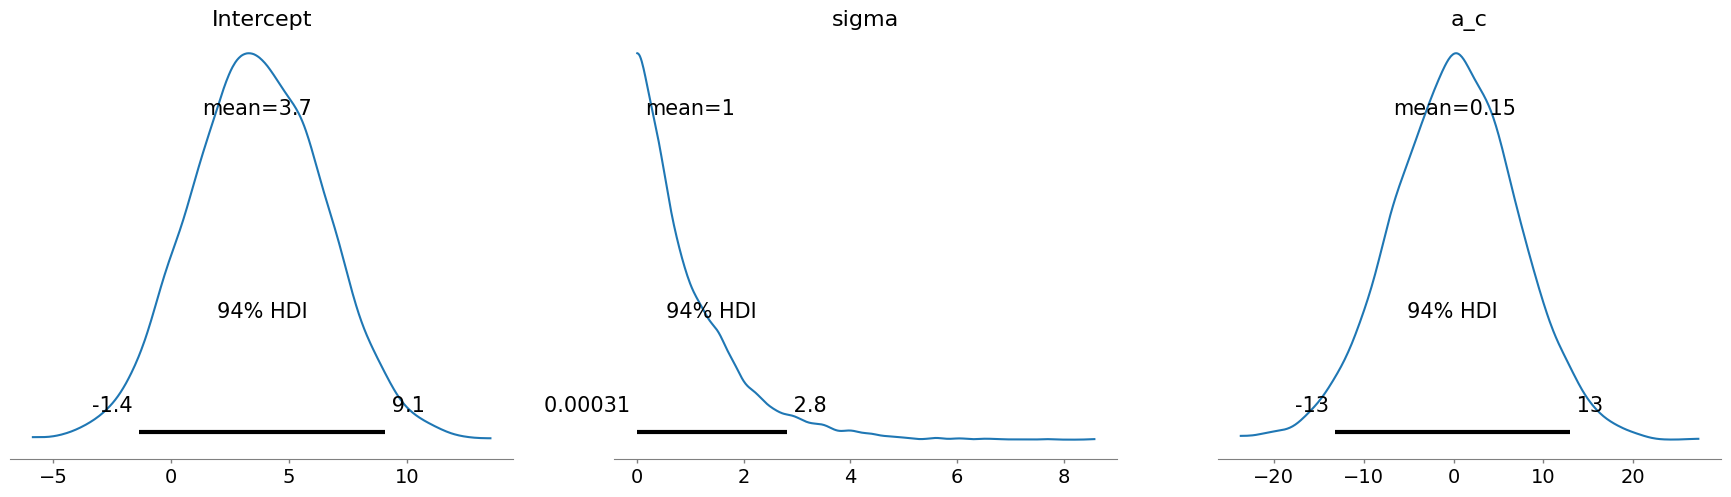

In [39]:
# ver distribuciones a priori
model_5.plot_priors()
plt.show()

Output()

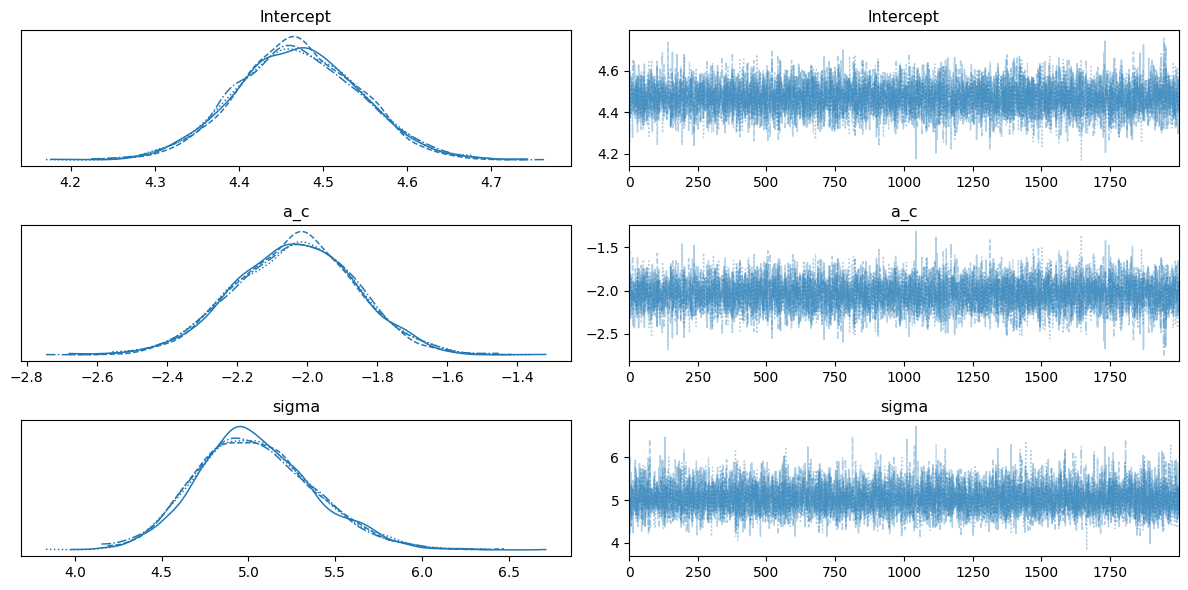

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.470  0.073   4.333    4.608      0.001    0.001    8049.0   
a_c       -2.035  0.173  -2.361   -1.716      0.002    0.002    7332.0   
sigma      5.040  0.340   4.452    5.714      0.003    0.004   11157.0   

           ess_tail  r_hat  
Intercept    5625.0    1.0  
a_c          5598.0    1.0  
sigma        6416.0    1.0

In [40]:
# Realizar la inferencia
results_5 = model_5.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_5)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_5)

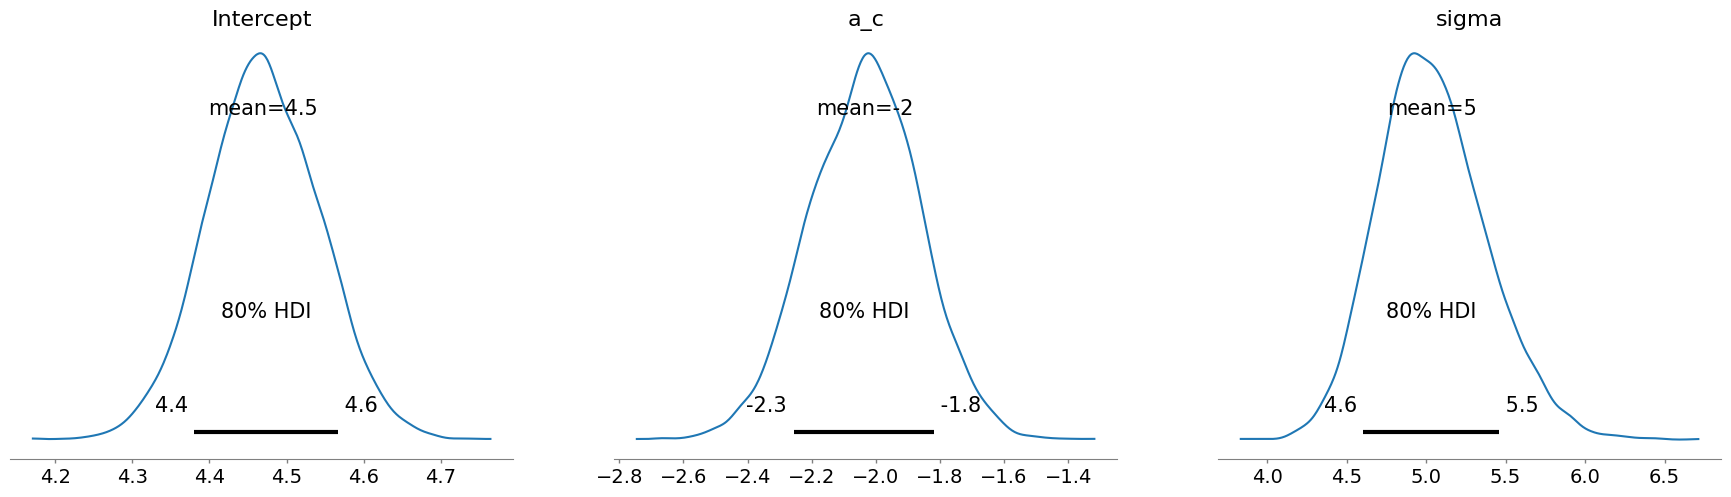

In [41]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_5,hdi_prob=0.8)
plt.show()

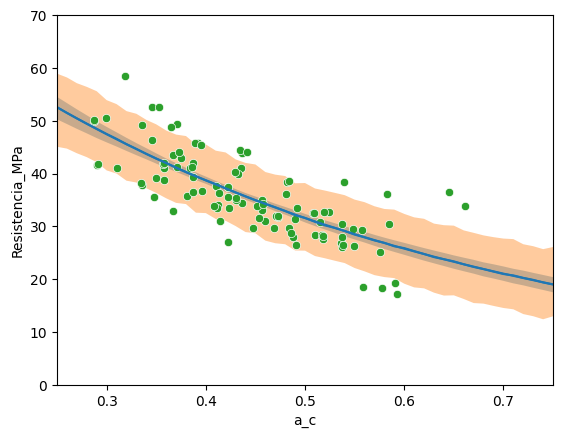

In [42]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_5,results_5,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_5,results_5,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

### Selección de modelos

#### Capacidad predictiva (PSIS-LOO CV)

In [43]:
# Calculo la logverosimilitud de cada modelo
model_1.compute_log_likelihood(results_1)
model_2.compute_log_likelihood(results_2)
model_3.compute_log_likelihood(results_3)
model_4.compute_log_likelihood(results_4)
model_5.compute_log_likelihood(results_5)

In [44]:
results_1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [45]:
# El modelo 4 es lognormal (ajusta log(Resistencia_MPa)), necesito transformar
results_4_T = results_4.map(lambda x: np.exp(x),groups='observed_vars',inplace=False)
results_4_T.rename({'log(Resistencia_MPa)':'Resistencia_MPa'},inplace=True)

# Eso incluye transformar log-verosimilutdes
results_4_T.map(lambda x: x-np.log(results_4_T.observed_data['Resistencia_MPa']),
                groups='log_likelihood',inplace=True)

In [46]:
# Genero un diccionario
model_dict = {'recta':results_1,'hipérbola':results_2,'parábola':results_3,
'Abrams (lognormal)':results_4_T,'Abrams (normal)':results_5}

# Calculo LOO-CV
model_comp = az.compare(model_dict)

# Tabla resumen
model_comp

rank    elpd_loo     p_loo  elpd_diff    weight        se  \
Abrams (normal)        0 -316.268480  3.415158   0.000000  0.613694  7.411624   
parábola               1 -316.652525  5.172251   0.384046  0.092135  6.935958   
hipérbola              2 -317.720095  2.010009   1.451615  0.294171  7.157854   
recta                  3 -318.677705  3.924163   2.409226  0.000000  7.878410   
Abrams (lognormal)     4 -322.339497  4.762254   6.071018  0.000000  8.839893   

                         dse  warning scale  
Abrams (normal)     0.000000    False   log  
parábola            1.543611    False   log  
hipérbola           2.909727    False   log  
recta               1.766454    False   log  
Abrams (lognormal)  3.814873    False   log

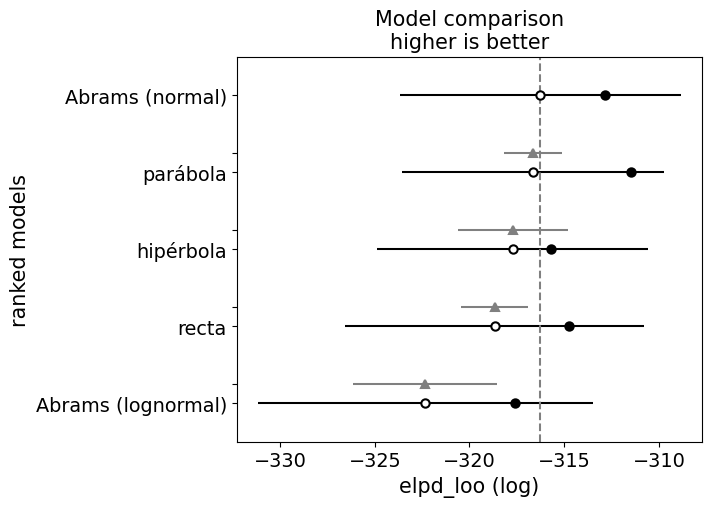

In [47]:
# Resumen grafico
az.plot_compare(model_comp,plot_ic_diff=True,insample_dev=True)
plt.show()

### Diagnóstico del Modelo "Ganador"

#### Verificación de la posterior predictiva

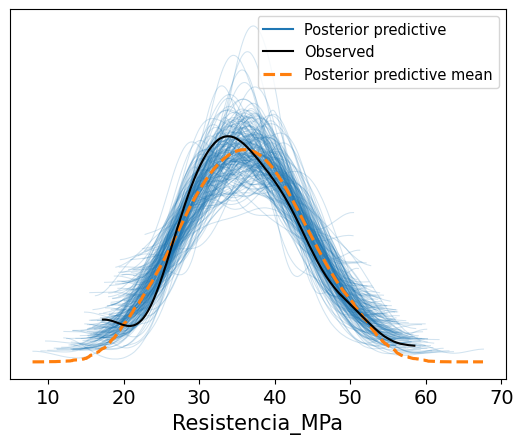

In [48]:
# Genero réplicas de mi dataset
model_5.predict(results_5,kind='response')

# Evaluación de la posterior predictiva
az.plot_ppc(results_5,num_pp_samples = 200)
plt.show()

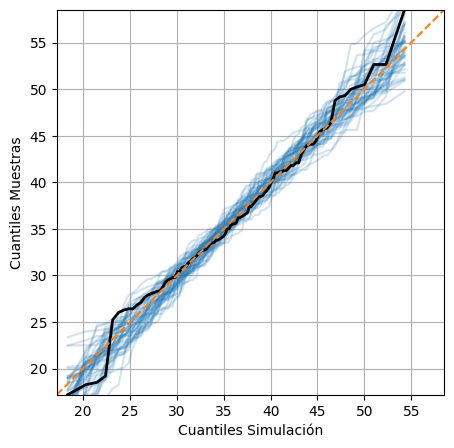

In [49]:
# QQ-PLOT
plot_qqplot(results_5,'Resistencia_MPa',50)
plt.show()

#### Análisis de residuos

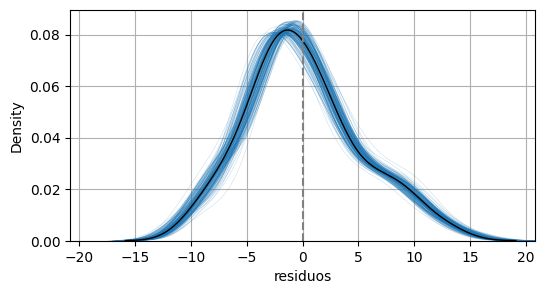

In [50]:
fig, ax = plot_residuos(df_horm,results_5,'Resistencia_MPa',num_pp_samples=200)
plt.show()

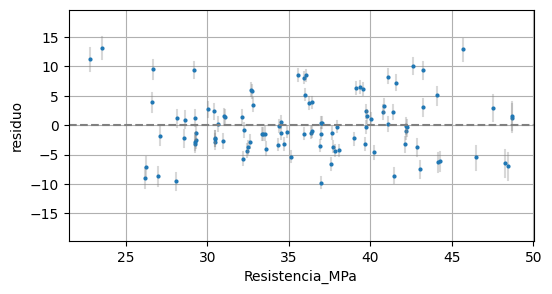

In [51]:
fig, ax = plot_residuos_2(df_horm,results_5,y='Resistencia_MPa')
plt.show()

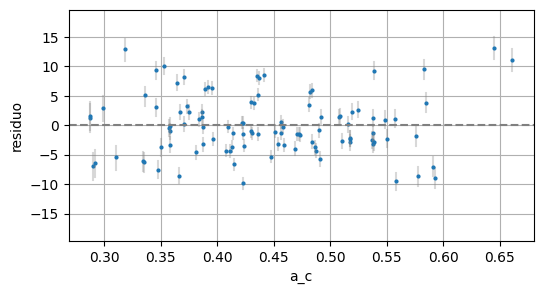

In [52]:
fig, ax = plot_residuos_2(df_horm,results_5,y='Resistencia_MPa',x='a_c')
plt.show()